In [24]:
!pip install prophet

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv('/content/Retail_Sales.csv')

In [46]:
df = df.rename(columns={'venda': 'sale', 'data': 'date','preco' : 'price'})

In [29]:
# Check for missing values
print(df.isnull().sum())

date       0
sale       0
estoque    0
price      0
dtype: int64


In [30]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     937 non-null    object 
 1   sale     937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   price    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB
None


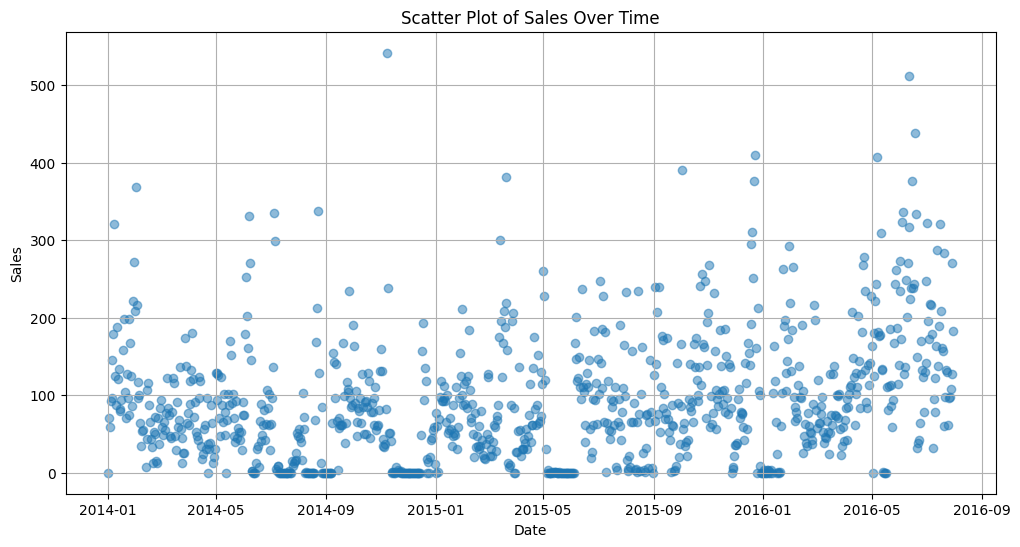

In [44]:
# Scatter plot: Date vs Sales
plt.figure(figsize=(12, 6))
plt.scatter(df['date'], df['sale'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Scatter Plot of Sales Over Time')
plt.grid(True)
plt.show()


In [32]:
# Sort by Date
df = df.sort_values('date')

split_date = '2016-02'

# Train-Test Split
train = df[df['date'] <= split_date]
test = df[df['date'] > split_date]

print(f'Train set shape: {train.shape}')
print(f'Test set shape: {test.shape}')

Train set shape: (755, 4)
Test set shape: (182, 4)


In [33]:
df = df.sort_values('date')

In [34]:
df.head()

,date,sale,estoque,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


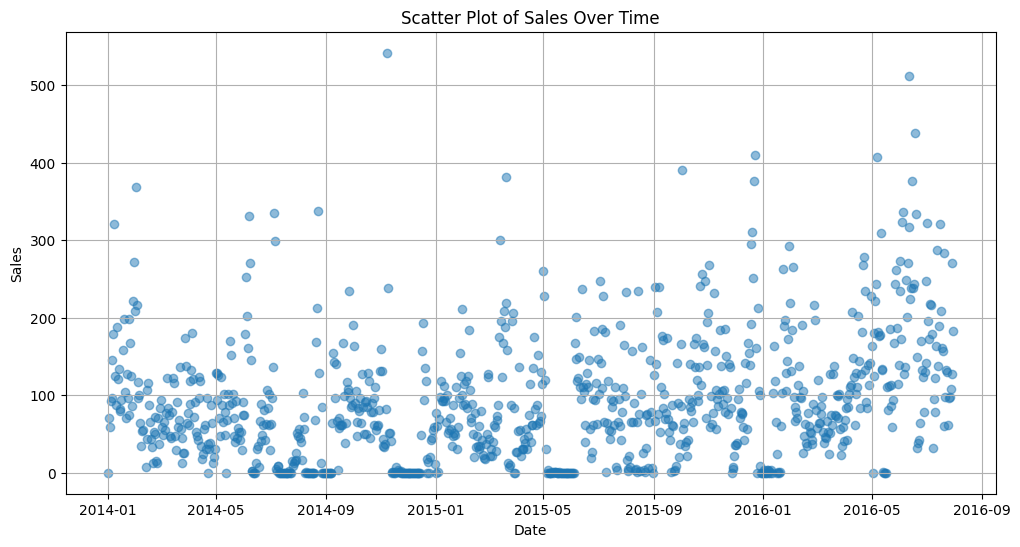

In [35]:
# converting 'date' column to 'datetimne'
df['date'] = pd.to_datetime(df['date'])

# Scatter plot: Date vs Sales
plt.figure(figsize=(12, 6))
plt.scatter(df['date'], df['sale'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Scatter Plot of Sales Over Time')
plt.grid(True)
plt.show()

In [36]:
# preparation of data for prophet
df_prophet = df[['date', 'sale','estoque']].rename(columns={'date': 'ds', 'sale': 'y'})

# Fit model
model = Prophet()
model.add_regressor('estoque')
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo0_ohj25/34ngfqhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo0_ohj25/hgvk217n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24053', 'data', 'file=/tmp/tmpo0_ohj25/34ngfqhk.json', 'init=/tmp/tmpo0_ohj25/hgvk217n.json', 'output', 'file=/tmp/tmpo0_ohj25/prophet_model5ajmcgl4/prophet_model-20250710172904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
# test set for Prophet
test_prophet = test[['date', 'sale','estoque']].rename(columns={'date': 'ds', 'sale': 'y'})

future = test_prophet[['ds', 'estoque']]

forecast = model.predict(future)

y_pred = forecast['yhat']
y_true = test_prophet['y']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Square Error: {rmse:.2f}')


Mean Absolute Error: 55.31
Root Mean Square Error: 72.49


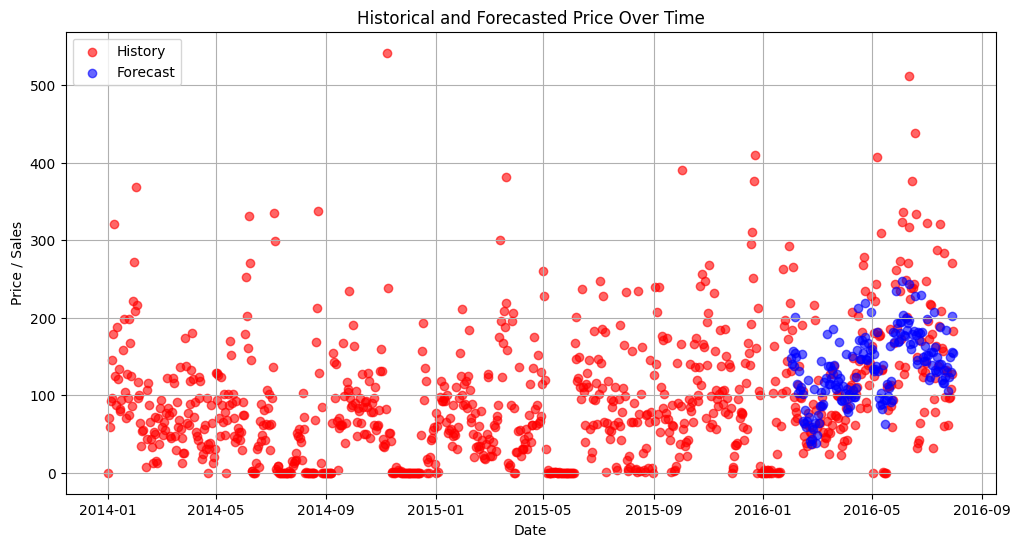

In [38]:
# historical data preparation
history = df[['date', 'sale']].rename(columns={'date': 'ds', 'sale': 'y'})
history = history.sort_values('ds')

future_forecast = forecast[['ds', 'yhat']]

# Scatter plot
plt.figure(figsize=(12, 6))

plt.scatter(history['ds'], history['y'], color='red', label='History', alpha=0.6)

plt.scatter(future_forecast['ds'], future_forecast['yhat'], color='blue', label='Forecast', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Price / Sales')
plt.title('Historical and Forecasted Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [39]:

# future dataframe for next 2 months
future = model.make_future_dataframe(periods=360, freq='D')

# Filling estoque for future dates

# Alternatively:
future['estoque'] = df_prophet['estoque'].mean()

# Predict for historical + future dates
forecast = model.predict(future)


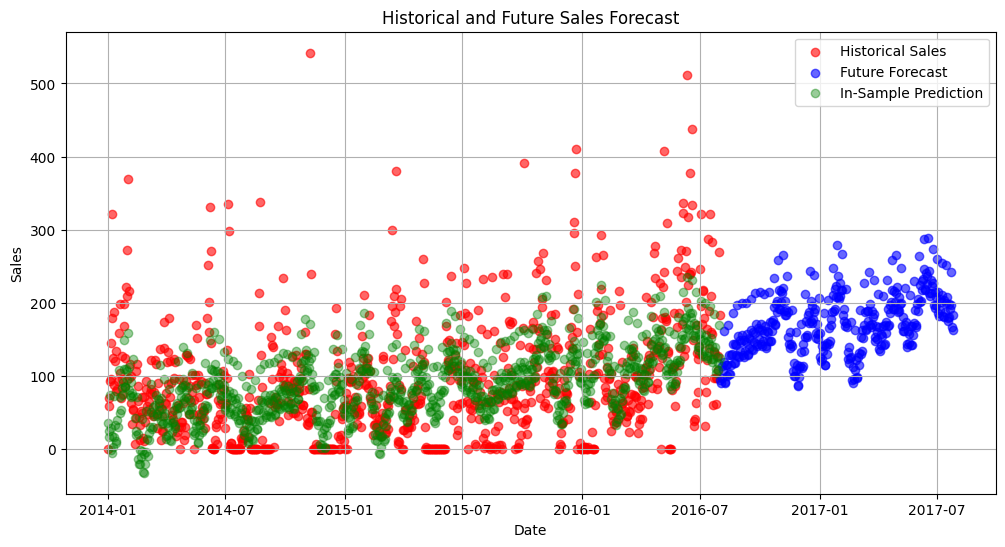

In [40]:
# Separate historical and future forecasts
cutoff_date = df_prophet['ds'].max()

# Plot
plt.figure(figsize=(12, 6))

plt.scatter(df_prophet['ds'], df_prophet['y'], color='red', label='Historical Sales', alpha=0.6)

# Future predictions in blue
plt.scatter(forecast[forecast['ds'] > cutoff_date]['ds'],
            forecast[forecast['ds'] > cutoff_date]['yhat'],
            color='blue', label='Future Forecast', alpha=0.6)

# Historical predictions
plt.scatter(forecast[forecast['ds'] <= cutoff_date]['ds'],
            forecast[forecast['ds'] <= cutoff_date]['yhat'],
            color='green', label='In-Sample Prediction', alpha=0.4)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Historical and Future Sales Forecast')
plt.legend()
plt.grid(True)
plt.show()


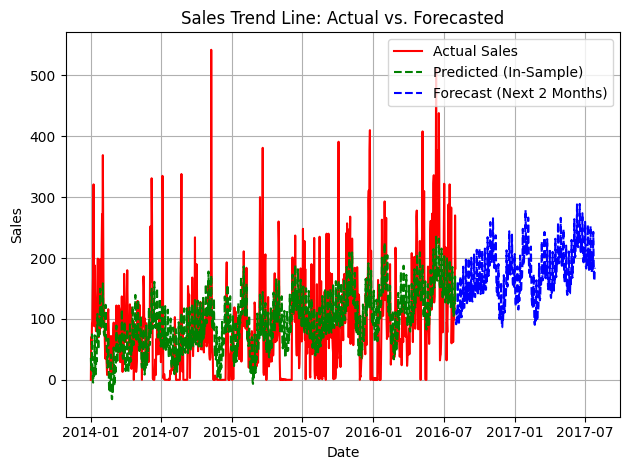

In [41]:
# line graph

# Actual sales (red line)
plt.plot(df_prophet['ds'], df_prophet['y'], color='red', label='Actual Sales')

# In-sample predictions (green line)
plt.plot(forecast[forecast['ds'] <= cutoff_date]['ds'],
         forecast[forecast['ds'] <= cutoff_date]['yhat'],
         color='green', linestyle='--', label='Predicted (In-Sample)')

# Future forecast (blue line)
plt.plot(forecast[forecast['ds'] > cutoff_date]['ds'],
         forecast[forecast['ds'] > cutoff_date]['yhat'],
         color='blue', linestyle='--', label='Forecast (Next 2 Months)')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Line: Actual vs. Forecasted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:

# future dataframe for next 2 months
future = model.make_future_dataframe(periods=360, freq='D')

# Fill estoque for future dates
# Option 1: Use last known estoque value
last_estoque = df_prophet['estoque'].iloc[-1]
future['estoque'] = last_estoque

# Predict for historical + future dates
forecast = model.predict(future)


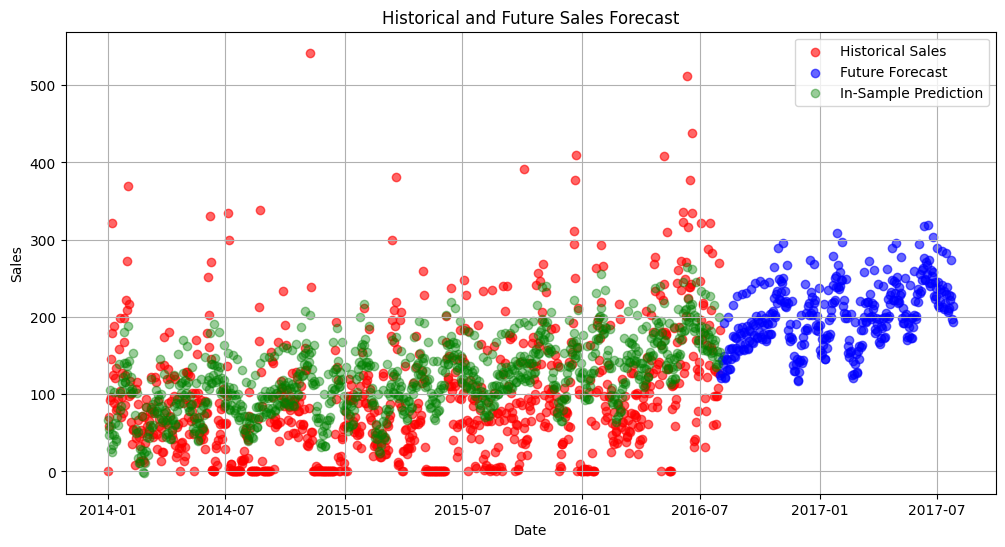

In [43]:
# Separate historical and future forecasts
cutoff_date = df_prophet['ds'].max()

# Plot
plt.figure(figsize=(12, 6))

plt.scatter(df_prophet['ds'], df_prophet['y'], color='red', label='Historical Sales', alpha=0.6)

# Future predictions in blue
plt.scatter(forecast[forecast['ds'] > cutoff_date]['ds'],
            forecast[forecast['ds'] > cutoff_date]['yhat'],
            color='blue', label='Future Forecast', alpha=0.6)

# Historical predictions
plt.scatter(forecast[forecast['ds'] <= cutoff_date]['ds'],
            forecast[forecast['ds'] <= cutoff_date]['yhat'],
            color='green', label='In-Sample Prediction', alpha=0.4)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Historical and Future Sales Forecast')
plt.legend()
plt.grid(True)
plt.show()